In [57]:
%matplotlib inline
#### Create Loan Data for Classification in Python ####
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from python.analysis import Plots

data = pd.read_csv("work/2023/Prod4a_1GeV_BeamSim_analysis/old_merge/merge-quantities.csv", nrows = 40000)
data = data[["alpha", "delta_x", "delta_xt", "delta_xl", "delta_phi", "d", "t", "p", "background"]]
data.head()

# do a preselection on delta_x
data = data[data["t"] < 200] #* picked this value based on plots in geometric-quantities.ipynb


In [59]:
features = ["alpha", "delta_x", "delta_xt", "delta_xl", "delta_phi", "d", "p"]
target = "background"

X = data[features]
y = data[target]


In [60]:
#Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
def Fit(X_train, y_train, X_test, n_estimators: int):
    clf = XGBClassifier(max_depth = 3, learning_rate = 0.3, n_estimators = n_estimators, objective = 'binary:logistic', booster = 'gbtree')
    
    # Printing all the parameters of XGBoost
    # print(clf)
    
    # Creating the model on Training Data
    XGB = clf.fit(X_train, y_train)
    prediction = XGB.predict(X_test)
    return XGB, prediction


def Report(answer, prediction):
    # Measuring accuracy on Testing Data
    # print("confusion matrix")
    matrix = metrics.confusion_matrix(answer, prediction)
    # TODO decide what information in the report is useful to me
    # print("report")
    # print(metrics.classification_report(answer, prediction))
    # print(matrix)
    return {
        "FPR" : matrix[0][1] / (matrix[0][1] + matrix[0][0]),
        "FNR" : matrix[1][0] / (matrix[1][0] + matrix[1][1])
    }

def PlotFeatureImportance(XGB):
    #Plotting the feature importance for Top 10 most important columns
    feature_importances = pd.Series(XGB.feature_importances_, index = features)
    feature_importances.nlargest(10).plot(kind = 'barh')


In [62]:
n_estimators = np.arange(1, 1011, 10)

rates = {"FPR" : [], "FNR" : []}
for n in n_estimators:
    print(n, end = '\r')
    XGB, prediction = Fit(X_train, y_train, X_test, n)
    r = Report(y_test, prediction)

    for k, v in r.items():
        rates[k].append(v)



[[  21   47]
 [  12 1797]]
              precision    recall  f1-score   support

       False       0.64      0.31      0.42        68
        True       0.97      0.99      0.98      1809

    accuracy                           0.97      1877
   macro avg       0.81      0.65      0.70      1877
weighted avg       0.96      0.97      0.96      1877

FPR


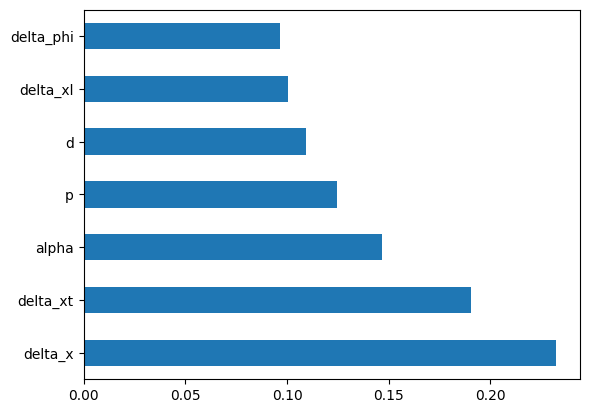

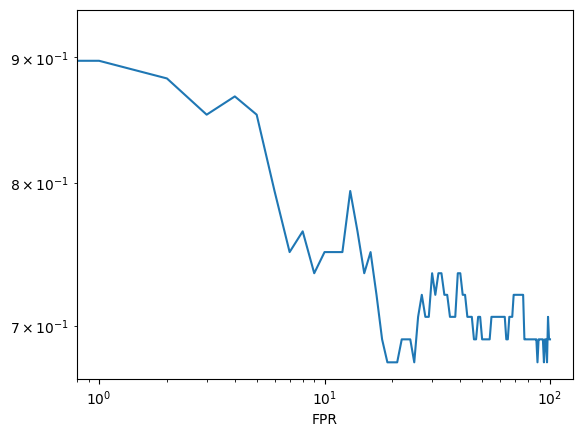

FNR


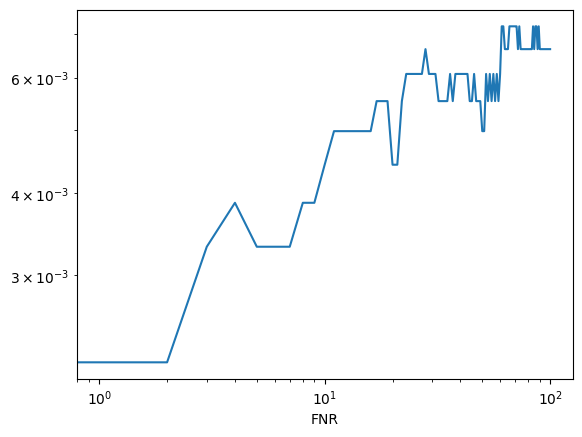

In [63]:
print(metrics.confusion_matrix(y_test, prediction))
print(metrics.classification_report(y_test, prediction))
PlotFeatureImportance(XGB)
for k in rates:
    print(k)
    Plots.plt.figure()
    Plots.plt.plot(rates[k])
    Plots.plt.xlabel(k)
    Plots.plt.yscale("log")
    Plots.plt.xscale("log")
    Plots.plt.show()

False precision = $\frac{tn}{tn + fn}$ - How often is the signal PFO correctly found?

True precision = $\frac{tp}{tp + fp}$ - How often is the background PFOs correctly found?

False recall = $\frac{tn}{tn + fp}$ - how often can it predict a PFO is signal

True recall = $\frac{tp}{tp + fn}$ - how often can it predict a PFO is background

False Positive rate = $\frac{fp}{fp + tn}$ - how often does it predict a signal PFO as background

False Negative rate = $\frac{fp}{fp + tn}$ - how often does it predict a background PFO as signal

